In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use("plotting.mplstyle")
import numpy as np
import sys
sys.path.append("./../code/")
from tqdm import tqdm
import glob,json

cbbh = '#1f78b4'
cnsbh = '#33a02c'
cbns = '#e31a1c'
cmisc = '#6a3d9a'

In [2]:
# Detection efficiencies of pipeline injection distributions (given by N_detected/N_total),
# as well as reweighted detection efficiency of "astrophysical" BBH population.
# See paper text for details
ref_efficiency_bbh = 0.0011009853783046646
ref_efficiency_bbh_2 = 0.0006770517089803911
ref_efficiency_bns = 0.016052332309165637
ref_efficiency_nsbh = 0.011199316130953239

# Number of draws used post-training to estimate detection efficiencies for the
# above populations (should match KS test in `run_network_training.py`)
n_bbh_ref1 = 3000
n_bbh_ref2 = 1000
n_bns_ref = 3000
n_nsbh_ref = 3000

# Expected binomial uncertainties
std_bbh_ref1 = np.sqrt(ref_efficiency_bbh*(1.-ref_efficiency_bbh)/n_bbh_ref1)
std_bbh_ref2 = np.sqrt(ref_efficiency_bbh_2*(1.-ref_efficiency_bbh_2)/n_bbh_ref2)
std_bns_ref = np.sqrt(ref_efficiency_bns*(1.-ref_efficiency_bns)/n_bns_ref)
std_nsbh_ref = np.sqrt(ref_efficiency_nsbh*(1.-ref_efficiency_nsbh)/n_nsbh_ref)

In [3]:
# Load json files with summary statistics for all runs
results = []
files = np.sort(glob.glob('./../data/trained_networks/job_*_ks.json'))
print(len(files))
nTrials = len(files)
for f in files:
    with open(f,'r') as jf:
        test = json.load(jf)
    results.append(test)
    
# Get detection efficiencies predicted by each neural net
bbh_f1 = np.array([results[i]['BBH']['det_efficiency'] for i in range(nTrials)])
bbh_f2 = np.array([results[i]['alt_pop_1']['det_efficiency'] for i in range(nTrials)])
bns_f1 = np.array([results[i]['BNS']['det_efficiency'] for i in range(nTrials)])
nsbh_f1 = np.array([results[i]['NSBH']['det_efficiency'] for i in range(nTrials)])

# Get normalized deviations from reference efficiencies
scaled_bbh_f1_residuals = np.abs(bbh_f1-ref_efficiency_bbh)/std_bbh_ref1
scaled_bbh_f2_residuals = np.abs(bbh_f2-ref_efficiency_bbh_2)/std_bbh_ref2
scaled_bns_f1_residuals = np.abs(bns_f1-ref_efficiency_bns)/std_bns_ref
scaled_nsbh_f1_residuals = np.abs(nsbh_f1-ref_efficiency_nsbh)/std_nsbh_ref

# Compute the maximum scaled residual for each network
full_efficiency_residuals = np.transpose([
    scaled_bbh_f1_residuals,
    scaled_bbh_f2_residuals,
    scaled_bns_f1_residuals,
    scaled_nsbh_f1_residuals
])
max_efficiency_residuals = np.max(full_efficiency_residuals,axis=1)
    
# Get KS-test statistic p-values
bbh_m = [results[i]['BBH']['m1_source'] for i in range(nTrials)]
bbh_d = [results[i]['BBH']['luminosity_distance'] for i in range(nTrials)]
bbh_inc = [results[i]['BBH']['cos_inclination'] for i in range(nTrials)]
bns_m = [results[i]['BNS']['m1_source'] for i in range(nTrials)]
bns_d = [results[i]['BNS']['luminosity_distance'] for i in range(nTrials)]
bns_inc = [results[i]['BNS']['cos_inclination'] for i in range(nTrials)]
nsbh_m = [results[i]['NSBH']['m1_source'] for i in range(nTrials)]
nsbh_d = [results[i]['NSBH']['luminosity_distance'] for i in range(nTrials)]
nsbh_inc = [results[i]['NSBH']['cos_inclination'] for i in range(nTrials)]

# Find minimum p-value for each network
full_p_values = np.transpose([
    bbh_m,
    bbh_d,
    bbh_inc,
    bns_m,
    bns_d,
    bns_inc,
    nsbh_m,
    nsbh_d,
    nsbh_inc,
])
min_logp_values = np.log10(np.min(full_p_values,axis=1))

76


In [5]:
# Index for chosen network
jobs = np.array([int(f.split('/')[-1].split('_')[1]) for f in files])
ind_to_highlight = np.where(jobs==27)[0]

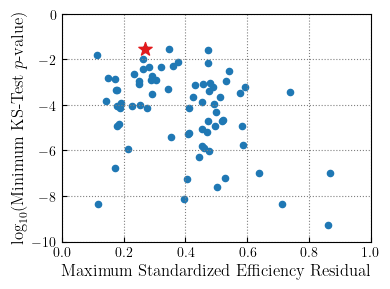

In [6]:
# Plot
fig,ax = plt.subplots(figsize=(4,3))
ax.scatter(max_efficiency_residuals,min_logp_values,s=20,color=cbbh)

ax.scatter(max_efficiency_residuals[ind_to_highlight],min_logp_values[ind_to_highlight],
           s=100,marker='*',color=cbns)

ax.set_xlabel('Maximum Standardized Efficiency Residual')
ax.set_ylabel('$\log_{10}$(Minimum KS-Test $p$-value)')
ax.set_xlim(0,1)
ax.set_ylim(-10,0)

plt.tight_layout()
plt.savefig('figure_13.pdf',bbox_inches='tight',dpi=400)

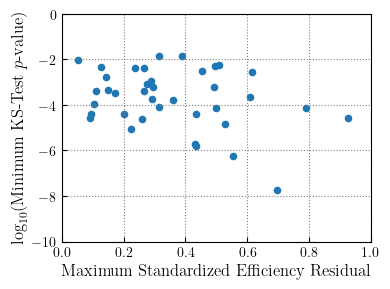

In [4]:
fig,ax = plt.subplots(figsize=(4,3))
ax.scatter(max_efficiency_residuals,min_logp_values,s=20,color=cbbh)

ax.set_xlabel('Maximum Standardized Efficiency Residual')
ax.set_ylabel('$\log_{10}$(Minimum KS-Test $p$-value)')
ax.set_xlim(0,1)
ax.set_ylim(-10,0)

plt.tight_layout()
#plt.savefig('figure_09.pdf',bbox_inches='tight',dpi=400)

In [5]:
jobs = np.array([int(f.split('/')[-1].split('_')[1]) for f in files])
print(jobs[np.argsort(min_logp_values)[::-1]])
print(np.sort(min_logp_values)[::-1])
print(max_efficiency_residuals[np.argsort(min_logp_values)[::-1]])
print(jobs[np.argsort(max_efficiency_residuals)])

[ 5  1 36 27  6  7 11 25  0 23 15  9 30 22 14  2 10 26 18 24 37 19  8 21
 33 35 39 17  4  3 32 20 34 16 38 31 12 28 13 29]
[-1.83334845 -1.87168553 -2.03911553 -2.25784572 -2.30116311 -2.33030194
 -2.39501077 -2.39550492 -2.49034742 -2.56059397 -2.76946081 -2.95724519
 -3.07256559 -3.19535807 -3.21988148 -3.33948724 -3.39019976 -3.40700621
 -3.49792912 -3.67069336 -3.75208866 -3.78912344 -3.97874602 -4.07346368
 -4.1278506  -4.13073316 -4.4006159  -4.40550074 -4.4146311  -4.58346545
 -4.59131856 -4.62232899 -4.83337276 -5.06010607 -5.72903561 -5.81738903
 -6.24925172 -6.43035404 -7.73651856 -9.49477902]
[0.31394961 0.38852767 0.05443516 0.50685972 0.4951879  0.12602855
 0.23809563 0.26585292 0.45374086 0.61527488 0.14412199 0.28978265
 0.27565499 0.49227616 0.29496785 0.15034323 0.26510834 0.11013332
 0.17340001 0.60896733 0.29051315 0.35826356 0.10566647 0.31490272
 0.50010683 0.79104561 0.09364215 0.20011826 0.43252136 0.0923655
 0.92634693 0.26107994 0.5283245  0.22382553 0.43239215